## 用2017年的数据进行训练，后面三个子集进行测试

In [1]:
# tensorflowGPU的设置
import tensorflow as tf

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
# 在同时具有CPU和GPU的设备上，优先使用GPU运算, 实际中可以使用with tf.device创建设备上下文
# 例如： with tf.decice('/CPU:0'): 
# 限制内存增长
tf.config.experimental.set_memory_growth(gpus[0], True)

## 总的数据处理

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf

from collections import Counter

data_csv = pd.read_csv('res_handle.csv')
# 按照时间维度划分为四个子集

data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']

def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False
    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]
data_train = data_2017.append(data_2018_1)
data_test_1 = data_2018_2
data_test_2 = data_2019

print(Counter(data_train.label), Counter(data_test_1.label), Counter(data_test_2.label))

data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.7, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.5, random_state=1).reset_index(drop=True)
data_train.shape, data_test_1.shape, data_test_2.shape

print(Counter(data_train['label']), Counter(data_test_1['label']), Counter(data_test_2['label']), Counter(data_csv['label']))

# data_csv.shape
print(data_csv.describe())

Counter({'virus': 1804, 'trojan': 1565, 'backdoor': 1411, 'worm': 1324}) Counter({'trojan': 778, 'virus': 769, 'backdoor': 659, 'worm': 436}) Counter({'virus': 1000, 'trojan': 930, 'worm': 865, 'backdoor': 861})
Counter({'virus': 1804, 'trojan': 1565, 'backdoor': 1411, 'worm': 1324}) Counter({'trojan': 542, 'virus': 534, 'backdoor': 472, 'worm': 301}) Counter({'virus': 483, 'trojan': 478, 'worm': 450, 'backdoor': 417}) Counter({'virus': 3573, 'trojan': 3273, 'backdoor': 2931, 'worm': 2625})
              length
count   12402.000000
mean     5652.612804
std     20251.140030
min         2.000000
25%       202.000000
50%      1105.500000
75%      2849.000000
max    780386.000000


In [16]:
name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}

# 训练数据
codes_train = data_train['name'].to_list()
labels_train = data_train['label'].map(lambda x: name2label[x])
labels_train = labels_train.to_list()
# 2018-06测试数据
codes_test_1 = data_test_1['name'].to_list()
labels_test_1 = data_test_1['label'].map(lambda x: name2label[x])
labels_test_1 = labels_test_1.to_list()
# 2019测试数据
codes_test_2 = data_test_2['name'].to_list()
labels_test_2 = data_test_2['label'].map(lambda x: name2label[x])
labels_test_2 = labels_test_2.to_list()

In [5]:
# 利用labelencoder构建opcode编码器

from sklearn import preprocessing
from tqdm import tqdm

opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)

# opcode词库的大小

print("opcode词库大小：", len(list(le.classes_)))

100%|██████████| 12402/12402 [00:07<00:00, 1635.08it/s]opcode词库大小： 641



In [6]:
# 数据预处理函数,选取opcode序列长度的四分位数2850进行padding操作
import numpy as np

def pad_data(res, max_len=2850):
    
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def load_data(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: len(codes) * 0.8]
        labels = labels[: len(codes) * 0.8]
    elif mode == 'val':    
        codes = codes[len(codes) * 0.8: ]
        labels = labels[len(codes) * 0.8: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [7]:
# 创建dataset对象

batch_size = 128
db_train = tf.data.Dataset.from_generator(load_data, args=[codes_train, labels_train, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(45)

db_val = tf.data.Dataset.from_generator(load_data, args=[codes_train, labels_train, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(40)

In [8]:
# 创建TextCNN类
from tensorflow import keras
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=4,
                 last_activation=None):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))

        # Embedding part can try multichannel as same as origin paper
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [2, 3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)
        d_1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
        d = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(d_1)

        output = Dense(self.class_num, activation=self.last_activation)(d)
        model = Model(inputs=input, outputs=output)
        return model

In [17]:
# 实例化TextCNN模型

max_len = 2850
max_features = 641
embedding_dims = 16

model = TextCNN(max_len, max_features, embedding_dims).get_model()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

In [18]:
history = model.fit(db_train,
                    epochs=40,
                    steps_per_epoch=40,
                    validation_data=db_val,
                    validation_steps=8)

Epoch 1/40
40/40 [==============================] - 45s 1s/step - loss: 3.6491 - categorical_accuracy: 0.4643 - val_loss: 2.2477 - val_categorical_accuracy: 0.5586
Epoch 2/40
40/40 [==============================] - 41s 1s/step - loss: 1.9787 - categorical_accuracy: 0.5929 - val_loss: 1.3188 - val_categorical_accuracy: 0.7656
Epoch 3/40
40/40 [==============================] - 40s 1s/step - loss: 1.1842 - categorical_accuracy: 0.7853 - val_loss: 0.8481 - val_categorical_accuracy: 0.8887
Epoch 4/40
40/40 [==============================] - 41s 1s/step - loss: 0.7776 - categorical_accuracy: 0.8906 - val_loss: 0.6408 - val_categorical_accuracy: 0.9238
Epoch 5/40
40/40 [==============================] - 43s 1s/step - loss: 0.6196 - categorical_accuracy: 0.9183 - val_loss: 0.5460 - val_categorical_accuracy: 0.9238
Epoch 6/40
40/40 [==============================] - 42s 1s/step - loss: 0.5316 - categorical_accuracy: 0.9349 - val_loss: 0.4965 - val_categorical_accuracy: 0.9268
Epoch 7/40
40/40

In [19]:
# 进行模型的保存,保存为textcnn_1

model.save('./model/textcnn_split.h5')
# model.summary()

# 测试

In [8]:
# 加载模型
import tensorflow as tf

model = tf.keras.models.load_model('./model/textcnn_split.h5') 

In [9]:
from tqdm import tqdm

def load_test_data(codes, labels):
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

def plot_multi_roc(y_lable, y_score, target_names, n_classes=2):
    # 计算每个类别的ROC曲线和AUC面积
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_lable[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 计算ROC曲线和AUC面积的微观平均（micro-averaging）
    fpr["micro"], tpr["micro"], _ = roc_curve(y_lable.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # 首先收集所有的假正率
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # 然后在此点内插所有ROC曲线
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # 最终计算平均和ROC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # 绘制全部的ROC曲线
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(target_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 6104/6104 [00:32<00:00, 185.32it/s]
<ipython-input-11-b4c9f18094b4>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


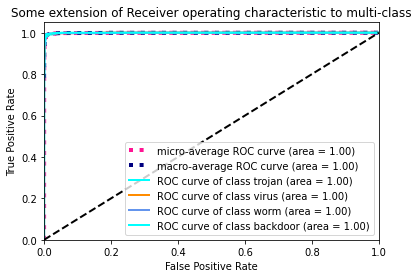

              precision    recall  f1-score   support

      trojan     0.9487    0.9917    0.9697      1565
        worm     0.9961    0.9884    0.9922      1804
       virus     0.9886    0.9849    0.9868      1324
    backdoor     0.9956    0.9589    0.9769      1411

    accuracy                         0.9817      6104
   macro avg     0.9822    0.9810    0.9814      6104
weighted avg     0.9822    0.9817    0.9817      6104



In [14]:
# 训练集

codes_train_copy, labels_train_copy = load_test_data(codes_train, labels_train)
y_pred = model.predict(codes_train_copy)
y_pred = tf.keras.backend.softmax(y_pred).numpy()

target_names = ('trojan', 'virus', 'worm', 'backdoor')

# plot_multi_roc(labels_train_copy, y_pred, target_names=target_names, n_classes=4)

y_pred = model.predict(codes_train_copy)
y_true = np.argmax(labels_train_copy, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 1849/1849 [00:12<00:00, 142.90it/s]
<ipython-input-11-b4c9f18094b4>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


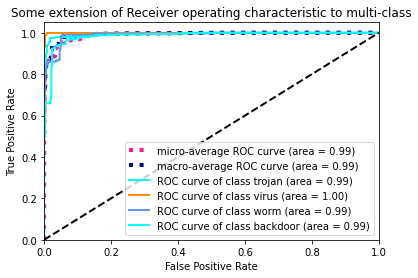

              precision    recall  f1-score   support

      trojan     0.7932    0.9834    0.8781       542
        worm     0.9638    0.9981    0.9807       534
       virus     0.9653    0.8306    0.8929       301
    backdoor     0.9096    0.7034    0.7933       472

    accuracy                         0.8913      1849
   macro avg     0.9080    0.8789    0.8862      1849
weighted avg     0.9002    0.8913    0.8885      1849



In [17]:

from sklearn.preprocessing import label_binarize
# 在第一个测试集上的准确率
codes_test_1_test, labels_test_1_test = load_test_data(codes_test_1, labels_test_1)

target_names = ('trojan', 'virus', 'worm', 'backdoor')
y_pred = model.predict(codes_test_1_test)
y_pred = tf.keras.backend.softmax(y_pred).numpy()
plot_multi_roc(labels_test_1_test, y_pred, target_names=target_names, n_classes=4)

y_true = np.argmax(labels_test_1_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 1828/1828 [00:08<00:00, 220.78it/s]
<ipython-input-11-b4c9f18094b4>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


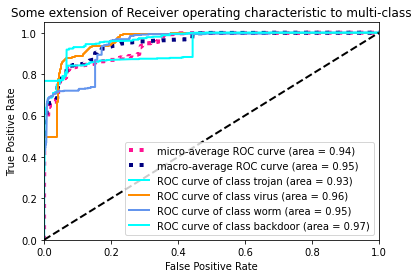

              precision    recall  f1-score   support

      trojan     0.6710    0.8577    0.7530       478
        worm     0.8608    0.8323    0.8463       483
       virus     0.9527    0.6711    0.7875       450
    backdoor     0.7714    0.8010    0.7859       417

    accuracy                         0.7921      1828
   macro avg     0.8140    0.7905    0.7932      1828
weighted avg     0.8134    0.7921    0.7936      1828



In [19]:
# 在第2019数据集上的准确率

codes_test_2_test, labels_test_2_test = load_test_data(codes_test_2, labels_test_2)
target_names = ('trojan', 'virus', 'worm', 'backdoor')
y_pred = model.predict(codes_test_2_test)
y_pred = tf.keras.backend.softmax(y_pred).numpy()
plot_multi_roc(labels_test_2_test, y_pred, target_names=target_names, n_classes=4)

y_true = np.argmax(labels_test_2_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

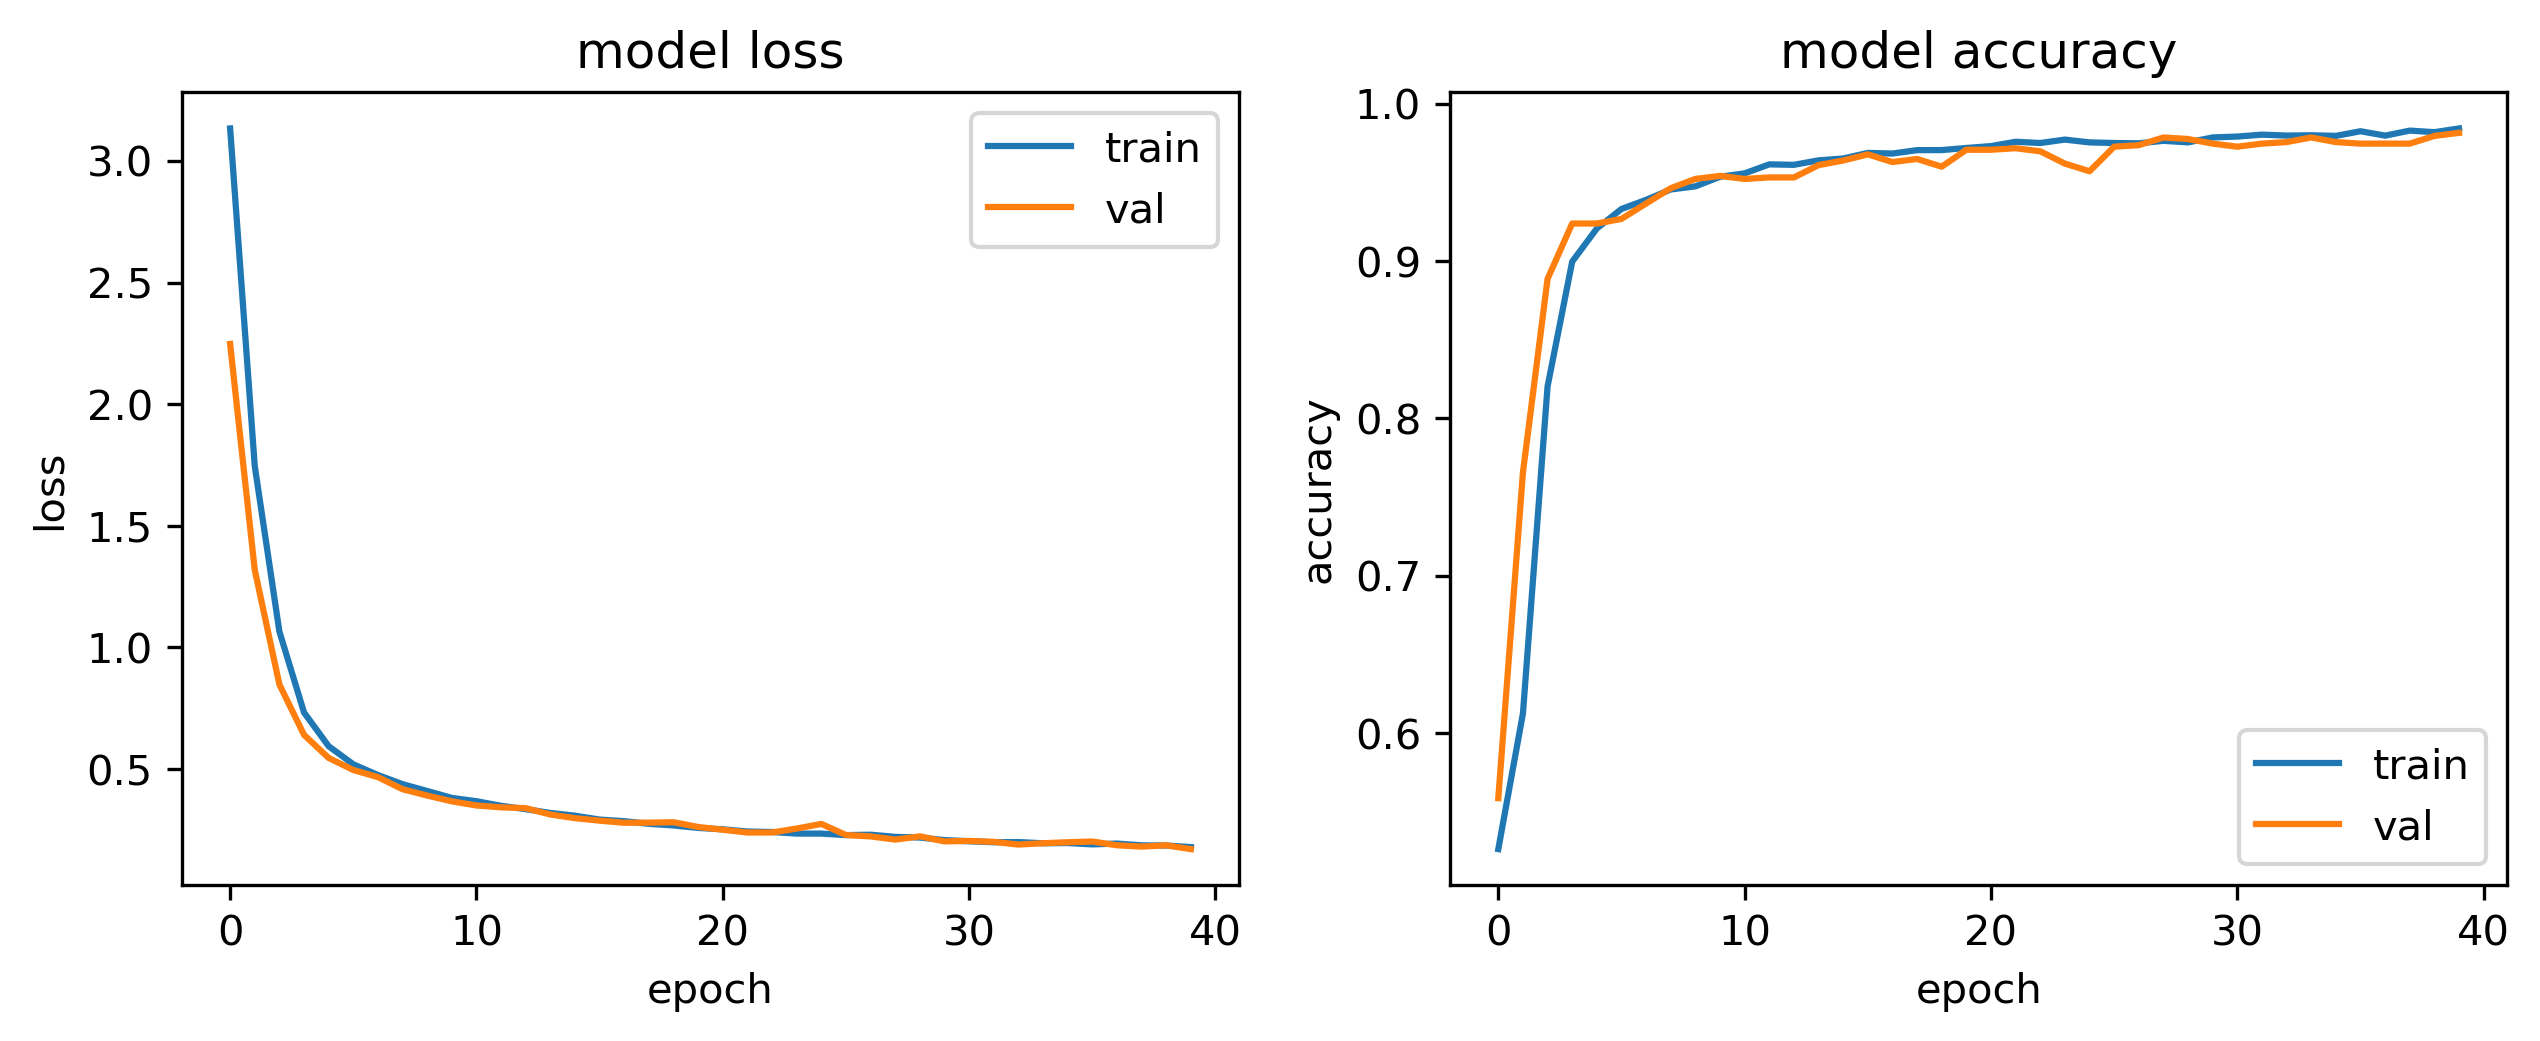

In [29]:
# 绘制loss和acc曲线
import matplotlib.pyplot as plt

def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')
    
PlotLoss('textcnn_split', history)

## 加入从two-head模型中得到的异常数据，重新训练

In [30]:
import pandas as pd 

data_ood = pd.read_csv("oodFromTwoHead.csv")
data_ood = data_ood.drop(['novelty', 'id'], axis=1)
name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}

# 训练数据
names_ood = data_ood['name'].to_list()
labels_ood = data_ood['label'].map(lambda x: name2label[x])
labels_ood = labels_ood.to_list()

In [36]:
# 创建dataset对象

batch_size = 128
db_train = tf.data.Dataset.from_generator(load_data, args=[names_ood+codes_train, labels_ood+labels_train, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(50)

db_val = tf.data.Dataset.from_generator(load_data, args=[names_ood+codes_train, labels_ood+labels_train, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(45)

In [37]:
# 加载模型
import tensorflow as tf

# model = tf.keras.models.load_model('./model/textcnn_split.h5') 
# 实例化TextCNN模型

max_len = 2850
max_features = 641
embedding_dims = 16

model = TextCNN(max_len, max_features, embedding_dims).get_model()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])
history = model.fit(db_train,
                    epochs=40,
                    steps_per_epoch=40,
                    validation_data=db_val,
                    validation_steps=8)

Epoch 1/40
40/40 [==============================] - 52s 1s/step - loss: 3.6822 - categorical_accuracy: 0.3160 - val_loss: 2.3169 - val_categorical_accuracy: 0.3018
Epoch 2/40
40/40 [==============================] - 61s 2s/step - loss: 2.0768 - categorical_accuracy: 0.4951 - val_loss: 1.5548 - val_categorical_accuracy: 0.5762
Epoch 3/40
40/40 [==============================] - 61s 2s/step - loss: 1.3603 - categorical_accuracy: 0.6134 - val_loss: 1.3435 - val_categorical_accuracy: 0.4482
Epoch 4/40
40/40 [==============================] - 61s 2s/step - loss: 1.0736 - categorical_accuracy: 0.6496 - val_loss: 1.0698 - val_categorical_accuracy: 0.5596
Epoch 5/40
40/40 [==============================] - 53s 1s/step - loss: 0.9957 - categorical_accuracy: 0.6231 - val_loss: 1.0051 - val_categorical_accuracy: 0.6406
Epoch 6/40
40/40 [==============================] - 47s 1s/step - loss: 0.8997 - categorical_accuracy: 0.6804 - val_loss: 0.8736 - val_categorical_accuracy: 0.6631
Epoch 7/40
40/40

In [38]:
from tqdm import tqdm

def load_test_data(codes, labels):
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res

In [39]:
codes_train_copy, labels_train_copy = load_test_data(codes_train, labels_train)

100%|██████████| 6104/6104 [00:33<00:00, 184.31it/s]


In [40]:
from sklearn.metrics import classification_report

y_pred = model.predict(codes_train_copy)
y_true = np.argmax(labels_train_copy, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9751    0.9744    0.9748      1565
       virus     0.9808    0.9895    0.9851      1804
        worm     0.9871    0.9804    0.9837      1324
      trojan     0.9829    0.9787    0.9808      1411

    accuracy                         0.9812      6104
   macro avg     0.9815    0.9808    0.9811      6104
weighted avg     0.9812    0.9812    0.9812      6104



In [44]:
codes_test_1, labels_test_1 = load_test_data(codes_test_1, labels_test_1)
codes_test_2, labels_test_2 = load_test_data(codes_test_2, labels_test_2)

100%|██████████| 1828/1828 [00:07<00:00, 248.94it/s]


In [45]:
from sklearn.preprocessing import label_binarize
# 在第一个测试集上的准确率

y_pred = model.predict(codes_test_1)
y_pred = tf.keras.backend.softmax(y_pred).numpy()
y_true = np.argmax(labels_test_1, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.9799    0.9908    0.9853       542
       virus     0.9780    1.0000    0.9889       534
        worm     0.9758    0.9369    0.9559       301
      trojan     0.9657    0.9534    0.9595       472

    accuracy                         0.9751      1849
   macro avg     0.9748    0.9703    0.9724      1849
weighted avg     0.9751    0.9751    0.9750      1849



In [46]:
# 在第二个测试集上的准确率
target_names = ('trojan', 'virus', 'worm', 'backdoor')
y_pred = model.predict(codes_test_2)
y_true = np.argmax(labels_test_2, axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    backdoor     0.8103    0.7594    0.7840       478
       virus     0.7808    0.9441    0.8547       483
        worm     0.9542    0.8333    0.8897       450
      trojan     0.9404    0.9089    0.9244       417

    accuracy                         0.8605      1828
   macro avg     0.8714    0.8614    0.8632      1828
weighted avg     0.8676    0.8605    0.8607      1828

